### y = m * x + b

A minimal example of linear regression in TensorFlow 2.0, written from scratch without using any built-in layers, optimizers, or loss functions. We'll create a few points on a scatter plot, then find the best fit line using the equation `y = m * x + b`.

### Bonus
When we're finished, we'll plot the error surface as a function of m and b, to visualize the gradient descent process. 

In [0]:
!pip install -q tensorflow==2.0.0-alpha0

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Model

Create a noisy dataset that's roughly linear, according to the equation y = m * x + b + noise.

In [0]:
def make_noisy_data(m=0.1, b=0.3, n=100):
  x = tf.random.uniform(shape=(n,))
  noise = tf.random.normal(shape=(len(x),), stddev=0.01)
  y = m * x + b + noise
  return x, y

In [0]:
x_train, y_train = make_noisy_data()

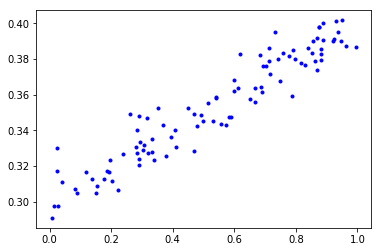

In [0]:
plt.plot(x_train, y_train, 'b.')

Define variables for our model. 

In [0]:
m = tf.Variable(0.)
b = tf.Variable(0.)

Predict y given x.

In [0]:
def predict(x):
  y = m * x + b
  return y

Our loss will be the squared difference between the predicted values and the true values.

In [0]:
def squared_error(y_pred, y_true):
  return tf.reduce_mean(tf.square(y_pred - y_true)) 

Calculate loss before training.

In [0]:
loss = squared_error(predict(x_train), y_train)
print("Starting loss", loss.numpy())

Starting loss 0.12565546


Use gradient descent to gradually improve our guess for `m` and `b`. At each step, we'll nudge them a little bit in the right direction to reduce the loss.

In [0]:
learning_rate = 0.05
steps = 200

for i in range(steps):
  
  with tf.GradientTape() as tape:
    predictions = predict(x_train)
    loss = squared_error(predictions, y_train)
    
  gradients = tape.gradient(loss, [m, b])
  
  m.assign_sub(gradients[0] * learning_rate)
  b.assign_sub(gradients[1] * learning_rate)
  
  if i % 20 == 0:    
    print("Step %d, Loss %f" % (i, loss.numpy()))

Step 0, Loss 0.125655
Step 20, Loss 0.000749
Step 40, Loss 0.000234
Step 60, Loss 0.000200
Step 80, Loss 0.000175
Step 100, Loss 0.000155
Step 120, Loss 0.000140
Step 140, Loss 0.000128
Step 160, Loss 0.000119
Step 180, Loss 0.000112


The learned values for m and b.

In [0]:
print ("m: %f, b: %f" % (m.numpy(), b.numpy()))


m: 0.114421, b: 0.291953


Plot the best fit line.

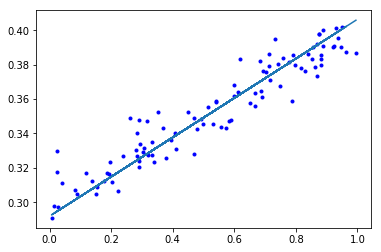

In [0]:
plt.plot(x_train, y_train, 'b.')
plt.plot(x_train, predict(x_train))

A couple things you can explore:

* To understand gradient descent, try printing out the `gradients` calculated below. See how they're used to adjust the variables (`m` and `b`).

* You can use TF 2.0 a lot like NumPy.  Try printing out the training data we created (`x_train`, `y_train`) and understand the format. Next, do the same for the variables (m and b). Notice both of these can be converted to NumPy format (with `.numpy()`).

### Bonus
Let's visualize the error surface. This section is included purely for fun, you can skip it without missing anything.

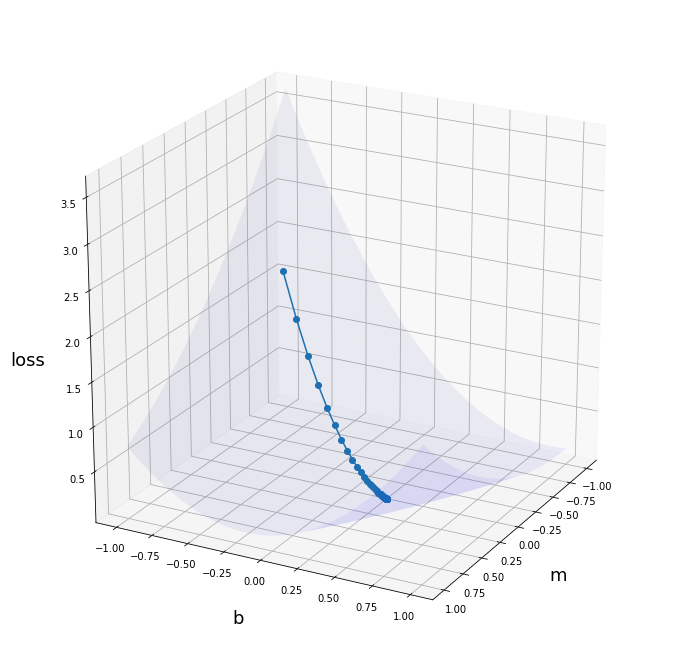

In [0]:
# Warning: hacky code ahead

import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# To plot the error surface, we'll need to get the loss
# for a bunch of different values for m and b.

ms = np.linspace(-1, 1)
bs = np.linspace(-1, 1)
m_mesh, b_mesh = np.meshgrid(ms, bs)

def loss_for_values(m, b):
  y = m * x_train + b
  loss = squared_error(y, y_train)
  return loss

zs = np.array([loss_for_values(m, b) for (m,b) in zip(np.ravel(m_mesh), 
                                                      np.ravel(b_mesh))])
z_mesh = zs.reshape(m_mesh.shape)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(m_mesh, b_mesh, z_mesh, color='b', alpha=0.06)

# At this point we have an error surface. 
# Now we'll need a history of the gradient descent steps.
# So as not to complicate the above code,
# let's retrain the model here, keeping
# track of m, b, and loss at each step.

# Intentionally start with this guess to 
# make the plot nicer
m = tf.Variable(-.5)
b = tf.Variable(-.75)

history = []

for i in range(steps):
  with tf.GradientTape() as tape:
    predictions = predict(x_train)
    loss = squared_error(predictions, y_train)
  gradients = tape.gradient(loss, [m, b])
  history.append((m.numpy(), b.numpy(), loss.numpy()))
  m.assign_sub(gradients[0] * learning_rate)
  b.assign_sub(gradients[1] * learning_rate)

# Plot the trajectory
ax.plot([h[0] for h in history], 
        [h[1] for h in history], 
        [h[2] for h in history],
        marker='o')

ax.set_xlabel('m', fontsize=18, labelpad=20)
ax.set_ylabel('b', fontsize=18, labelpad=20)
ax.set_zlabel('loss', fontsize=18, labelpad=20)

ax.view_init(elev=22, azim=28)